<a href="https://colab.research.google.com/github/xaximpvp2/master/blob/main/codigo_aula21_Avaliando_a_performance_de_uma_rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Avaliando a qualidade de uma rede neural (problema de classificação)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')

tf.autograph.set_verbosity(0)

### Conjunto de dados

Rode a célula abaixo para gerar o conjunto de dados e para dividí-lo em dados de treinamento, validação-cruzada (CV) e dados de teste. Neste exemplo, usaremos propositalmente uma porcentagem maior para dados de validação cruzada para dar ênfase aos resultados encontrados

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Gerando dados
classes = 6     # qtdade de classes
m       = 800   # qtdade de amostras
desvio  = 0.4   # desvio em relação aos centros
centros = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
X, y    = make_blobs(n_samples=m, centers=centros, cluster_std=desvio, random_state=2, n_features=2)


# Dividindo os dados.
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


Abaixo nós importamos algumas funções auxiliares que serão usadas neste código

In [ ]:
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.widgets import Button, CheckButtons
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

from ipywidgets import Output
np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')


# Plota fronteira de decisão para múltiplas classes
# Essa versão lida com uma previsão não-vetorizada (adiciona um loop for sobre os pontos)
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # Cria grade de pontos
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]

    #faz previsão para cada ponto
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    # Plot de contorno destaca as fronteiras entre os valores - classes nesse caso
    ax.contour(xx, yy, Z, colors=color, linewidths=lw)
    ax.axis('tight')

def recat(pt, origins):
    """ Classifica um ponto com base na distância dos clusters de origem """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Dados treinamento, Dados CV")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    # construindo modelo para rotinas de plot
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("performance ideal", fontsize=14)

    # Adiciona os dados originais à fronteira de decisão
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()


def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    # Plota a fronteira de decisão
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("dados treinamento", fontsize=14)

    # Adiciona os dados originais à fronteira de decisão
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("dados validação cruzada", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes,
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()


# Não usada mas calcula o erro sumando equidistância
def err_all_equal(X_train,X_cv,X_test, y_train,y_cv,y_test, centers):
    X_all = np.concatenate((X_train,X_cv,X_test), axis=0)
    y_all = np.concatenate((y_train,y_cv,y_test), axis=0)
    m = len(X_all)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X_all[i], centers)
    err_all = eval_cat_err(y_all, y_eq)
    return(err_all)

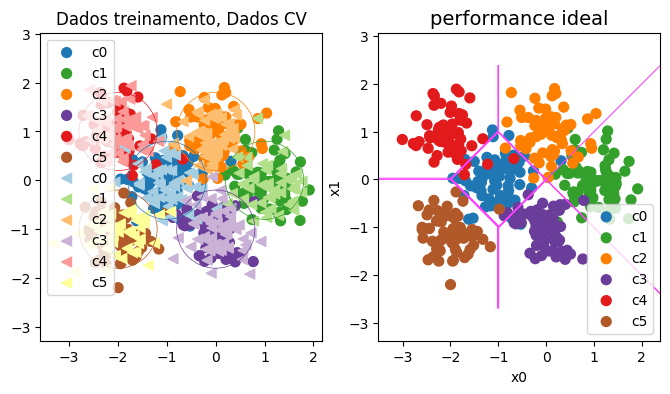

In [ ]:
plt_train_eq_dist(X_train, y_train, classes, X_cv, y_cv, centros, desvio)

Acima, no gráfico da esquerda, você consegue ver os dados. Há 6 diferentes agrupamentos de amostras (clusters), identificados pelas diferentes cores. Tanto os dados de treinamento (pontos) como os dados de validação cruzada (triângulos) estão presentes. Os pontos interessantes são aqueles que estão localizados em regiões ambíguas. Como você acha que uma rede neural classificará tais amostras? Você espera que ocorra overfitting ou underfitting?

No gráfico da direita temos um exemplo do que pode ser considerado como sendo um modelo 'ideal' de referência. As linhas representam fronteiras de 'distâncias iguais' onde a distância entre os centros é igual. Esse modelo classifica de forma equivocada apenas 8% dos dados.


### Avaliando a qualidade de um modelo de classificação usando a taxa de erro

Para modelos que realizam classificação, podemos usar como métrica para availação da qualidade desse modelo a fração de amostras com previsão incorreta:

$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1}
\begin{cases}
    1, & \text{se $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{caso contrário}
\end{cases}
$$

Abaixo, tem-se uma função que automatiza o cálculo da taxa de erro. Note que, neste nosso código, os valores alvo são o índice da categoria (não trata-se de uma codificação do tipo [one-hot bit](https://en.wikipedia.org/wiki/One-hot)).

In [ ]:
def calcula_erro_classificacao(y, y_chapeu):
    """
    Calcula o erro de categorização
    Argumentos:
      y    : (ndarray  Shape (m,) ou (m,1))  categorias alvo
      y_chapeu : (ndarray  Shape (m,) ou (m,1))  categorias previstas
    Retorna:
      classe_erro: (escalar)
    """
    m         = len(y)
    incorreto = 0
    for i in range(m):
        if(y_chapeu[i]!=y[i]):
            incorreto+=1
    classe_erro=incorreto/m
    return(classe_erro)

In [ ]:
# Abaixo testamos a implementação da nossa função:

y_chapeu = np.array([1, 2, 0])
y_tmp    = np.array([1, 2, 3])
print(f"erro de classificação encontrado: {np.squeeze(calcula_erro_classificacao(y_chapeu, y_tmp)):0.3f}, resultado esperado: 0.333" )
y_chapeu = np.array([[1], [2], [0], [3]])
y_tmp    = np.array([[1], [2], [1], [3]])
print(f"erro de classificação encontrado: {np.squeeze(calcula_erro_classificacao(y_chapeu, y_tmp)):0.3f}, resultado esperado: 0.250" )


erro de classificação encontrado: 0.333, resultado esperado: 0.333
erro de classificação encontrado: 0.250, resultado esperado: 0.250


Na célula acima, teste diferentes exemplos para verificar seu entendimento acerca da taxa de erro de classificação

## Modelo complexo

Abaixo criamos uma rede neural complexa para tentar resolver tal problema de classificação.

In [ ]:
tf.random.set_seed(1234) # define uma semente fixa para o gerador de números aleatórios do tensorflow
modelo = Sequential(
    [
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="softmax")
    ], name="Modelo_complexo"
)
modelo.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

In [ ]:
modelo.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3410
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4766  
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3507  
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2977 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2432
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2168  
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2217  
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2165 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2021  
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1940 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1927  
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1936 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1912  
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1884 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━

In [ ]:
modelo.summary()

Model: "Modelo_complexo"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 120)                 │             360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 40)                  │           4,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


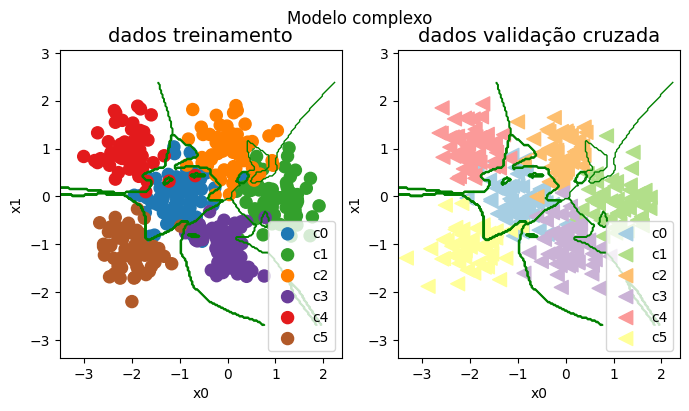

In [ ]:
#abaixo criamos um modelo para realizar previsões. Deixamos em aberto quem será a matriz de características de entrada Xl.
modelo_previsao = lambda Xl: np.argmax(tf.nn.softmax(modelo.predict(Xl)).numpy(),axis=1)


plt_nn(modelo_previsao,X_train,y_train, classes, X_cv, y_cv, suptitle="Modelo complexo")

Olhando no gráfico da esquerda, note que esse modelo complexo se esforçou para capturar amostras distoantes (outliers) de cada categoria. O problema é que tais amostras distoantes não representam o comportamento fundamental presente nesses dados. O resultado disso é um modelo que erra na classificação de diversas amostras presentes nos dados de validação cruzada (gráfico da direita).

Abaixo nós calculamos a taxa de erro de classificação.

In [ ]:
training_cerr_complex = calcula_erro_classificacao(y_train, modelo_previsao(X_train))
cv_cerr_complex       = calcula_erro_classificacao(y_cv, modelo_previsao(X_cv))
print(f"taxa de erro, treinamento, modelo complexo: {100*training_cerr_complex:0.3f} %")
print(f"taxa de erro, cv,          modelo complexo: {100*cv_cerr_complex:0.3f} %")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
taxa de erro, treinamento, modelo complexo: 0.500 %
taxa de erro, cv,          modelo complexo: 9.688 %


Nota-se uma diferença muito significativa entre as duas taxas de erro. Temos um forte indicativo de que o modelo encontra-se sobreestimando os dados de treinamento (overfitting).

## Modelo simples

Abaixo criamos uma rede neural mais simples para tentar resolver tal problema de classificação.

In [ ]:
tf.random.set_seed(1234)
modelo_simples = Sequential(
    [
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
    ], name = "Modelo_simples"
)
modelo_simples.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)


In [ ]:
modelo_simples.fit(
    X_train,y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1459  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7381 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5681 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4313 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2732 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0935 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9071  
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7420 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6168 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5284 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4669 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4238 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3927 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3696 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
modelo_simples.summary()

Model: "Modelo_simples"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                     │ (None, 6)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 6)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182 (1.42 KB)

 Trainable params: 60 (480.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122 (976.00 B)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


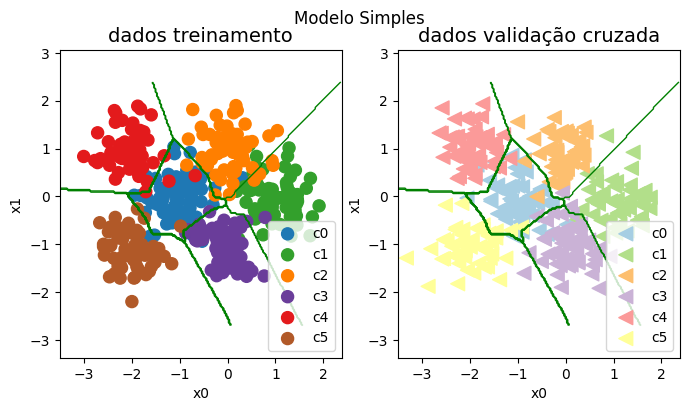

In [ ]:
#abaixo criamos um modelo para realizar previsões. Deixamos em aberto quem será a matriz de características de entrada Xl.
modelo_previsao_simples = lambda Xl: np.argmax(tf.nn.softmax(modelo_simples.predict(Xl)).numpy(),axis=1)


plt_nn(modelo_previsao_simples,X_train,y_train, classes, X_cv, y_cv, suptitle="Modelo Simples")

Esse modelo mais simples parece bem melhor. Vamos calcular os erros:

In [ ]:
training_cerr_simples = calcula_erro_classificacao(y_train, modelo_previsao_simples(X_train))
cv_cerr_simples       = calcula_erro_classificacao(y_cv, modelo_previsao_simples(X_cv))
print(f"taxa de erro, treinamento, modelo simples: {100*training_cerr_simples:0.3f} %")
print(f"taxa de erro, cv,          modelo simples: {100*cv_cerr_simples:0.3f} %")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
taxa de erro, treinamento, modelo simples: 5.750 %
taxa de erro, cv,          modelo simples: 8.125 %


Em comparação com o modelo mais complexo, note que o modelo mais simples tem uma taxa de erro de classificação um pouco maior para os dados de treinamento, porém sua taxa de erro para dados de validação cruzada é menor.

Ou seja, conseguimos assim resolver o problema de overfitting. Será que conseguimos obter um modelo ainda melhor?


## Regularização

Assim como no caso da regressão polinomial, é possível aplicar o conceito de regularização para moderar o impacto de um modelo mais complexo.

Abaixo, nós reconstruímos o modelo complexo, mas agora incluindo um termo de regularização.

In [ ]:
tf.random.set_seed(1234)
modelo_regularizado = Sequential(
    [
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # note o termo de regularização aqui
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # note o termo de regularização aqui
        tf.keras.layers.Dense(6, activation="linear")
    ], name= "Modelo_com_regularizacao"
)
modelo_regularizado.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)


In [ ]:
modelo_regularizado.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.9111
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7314  
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3391 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1024 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0131  
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9462  
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8987 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8543  
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8158 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7824
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7559 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7393 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7242 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7147 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
modelo_regularizado.summary()

Model: "Modelo_com_regularizacao"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                     │ (None, 120)                 │             360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 40)                  │           4,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


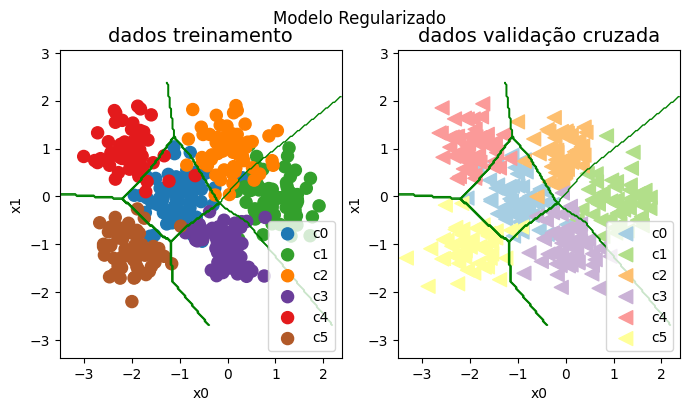

In [ ]:
#abaixo criamos um modelo para realizar previsões. Deixamos em aberto quem será a matriz de características de entrada Xl.
modelo_previsao_regularizado = lambda Xl: np.argmax(tf.nn.softmax(modelo_regularizado.predict(Xl)).numpy(),axis=1)

plt_nn(modelo_previsao_regularizado, X_train,y_train, classes, X_cv, y_cv, suptitle="Modelo Regularizado")

Estes resultados são muito parecidos com aqueles apresentados pelo modelo ideal. Abaixo nós calculamos os erros associados

In [ ]:
training_cerr_regularizado = calcula_erro_classificacao(y_train, modelo_previsao_regularizado(X_train))
cv_cerr_regularizado       = calcula_erro_classificacao(y_cv, modelo_previsao_regularizado(X_cv))
print(f"taxa de erro, treinamento, modelo regularizado: {100*training_cerr_regularizado:0.3f} %")
print(f"taxa de erro, cv,          modelo regularizado: {100*cv_cerr_regularizado:0.3f} %")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
taxa de erro, treinamento, modelo regularizado: 7.250 %
taxa de erro, cv,          modelo regularizado: 6.562 %


Compare os resultados obtidos para os três modelos.


## Em busca do $\lambda$ ótimo

Assim como nós fizemos para a regressão linear, nós podemos tentar diferentes valores para o parâmetro de regularização $\lambda$. Este código pode levar vários minutos para rodar.

In [45]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.45]
modelos=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_    = lambdas[i]
    modelos[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    modelos[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    modelos[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"lambda testado = {lambda_}")


Streaming output truncated to the last 5000 lines.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4151  
Epoch 503/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4149  
Epoch 504/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4147  
Epoch 505/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4146  
Epoch 506/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4144  
Epoch 507/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4143  
Epoch 508/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4143 
Epoch 509/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4139  
Epoch 510/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4139  
Epoch 511/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4135  
Epoch 512/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4135  
Epoch 513/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4132  
Epoch 514/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4131
Epoch 515/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

Abaixo nós plotamos os resultados obtidos

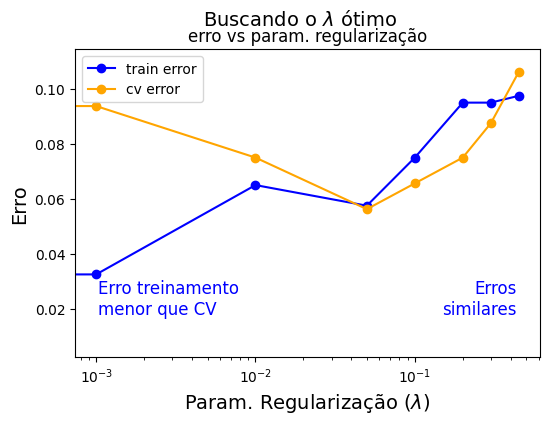

In [46]:
err_train = np.zeros(len(lambdas))
err_cv = np.zeros(len(lambdas))
for i in range(len(modelos)):
    err_train[i] = calcula_erro_classificacao(y_train,np.argmax( modelos[i](X_train), axis=1))
    err_cv[i] = calcula_erro_classificacao(y_cv, np.argmax( modelos[i](X_cv), axis=1))

fig, ax = plt.subplots(1,1,figsize=(6,4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax.set_title("erro vs param. regularização",fontsize = 12)
ax.plot(lambdas, err_train, marker='o', label="train error", color = "blue")
ax.plot(lambdas, err_cv,    marker='o', label="cv error",    color = "orange")
ax.set_xscale('log')
ax.set_ylim(*ax.get_ylim())
ax.set_xlabel("Param. Regularização ($\lambda$)",fontsize = 14)
ax.set_ylabel("Erro",fontsize = 14)
ax.legend()
fig.suptitle("Buscando o $\lambda$ ótimo",fontsize = 14)
ax.text(0.05,0.14,"Erro treinamento\nmenor que CV",fontsize=12, ha='left',transform=ax.transAxes,color = "blue")
ax.text(0.95,0.14,"Erros\nsimilares",    fontsize=12, ha='right',transform=ax.transAxes,color = "blue")
plt.show()

Qual valor para o parâmetro de regularização você escolheria?